# ImpDAR Autopicking Tutorial

## Introduction

- what is picking, why is it important, link [this tutorial](https://github.com/Jakidxav/ImpDAR_tutorials/tree/master/plot_power)

- maybe add in Ben's figure from SCG 2017-18

### Semi-automated Picking
- Discus what ImpDAR is currently doing

- Include images from GLunch talk
- Show autopicking video

### Fully Automated Picking
- Link to README for work already done

- Where is this line from? From NEGIS or the Northeast Greenland Ice Stream (year, significance).

<img src="./images/picking_example.gif" width="750" align="center">

In [1]:
# We get annoying warnings about backends that are safe to ignore
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import copy

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar

from skimage import measure
from skimage.filters import gaussian

from impdar.lib import load
from impdar.lib import plot
from impdar.lib import process
from autopicker_methods import *

## Loading Data

In [2]:
#file on disk
green_mat = './data/nline5.mat'

#load in data
dat = load.load('mat', green_mat)[0]

In [3]:
vars(dat)

{'chan': 1,
 'data': array([[ 1.6573445e+04,  1.6879803e+04,  1.6720752e+04, ...,
          2.2557945e+04,  2.2430016e+04,  2.2409408e+04],
        [ 1.6404561e+04,  1.6689334e+04,  1.6548559e+04, ...,
          2.2425178e+04,  2.2307602e+04,  2.2284225e+04],
        [ 1.6235407e+04,  1.6500377e+04,  1.6376154e+04, ...,
          2.2292615e+04,  2.2184711e+04,  2.2159469e+04],
        ...,
        [-1.3460696e+00, -9.0857440e-01, -8.5832715e-01, ...,
         -3.0521524e-01, -3.1189924e-01, -7.1386606e-01],
        [-1.4388833e+00, -9.6377879e-01, -7.8529817e-01, ...,
         -2.8597730e-01, -2.2767024e-01, -6.3531178e-01],
        [-1.5138711e+00, -1.0075097e+00, -7.0039809e-01, ...,
         -2.6328605e-01, -1.4156653e-01, -5.4718399e-01]], dtype=float32),
 'decday': array([nan, nan, nan, ..., nan, nan, nan]),
 'dt': 5e-09,
 'lat': array([75.747521  , 75.74747735, 75.74743412, ..., 75.5931702 ,
        75.59312396, 75.59307845]),
 'long': array([-36.31617382, -36.31593759, -36.31570

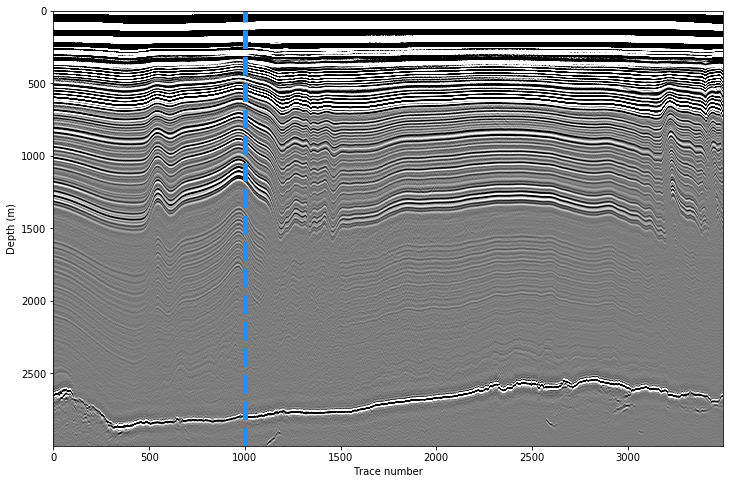

In [50]:
fig, ax = plot.plot_radargram(dat, ydat='depth')
ax.axvline(x=1000, color='dodgerblue', linewidth=5.0, linestyle='--')
plt.show()

### For the purpose of the tutorial, try to create GLunch figures in this Notebook instead of including images.

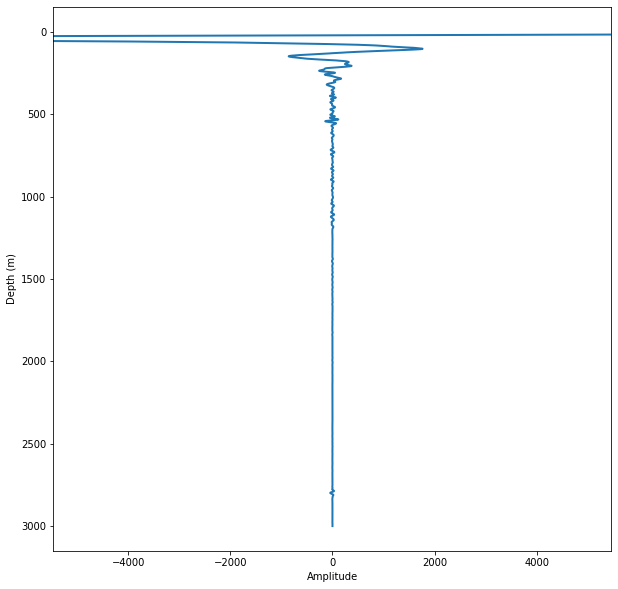

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
plot.plot_traces(dat, 1000, ydat='depth', linewidth=2.0, linestyle='solid', fig=fig, ax=ax)
plt.show()

Significant ringing at the surface (large return) is making it difficult to see what is happening deeper into the icesheet. Let's zoom in a bit. The signal is steadily decaying until about 2700m when we see a bigger return from the bedrock. To confirm this, look at the above radargram for trace 1000 and you will see this to be the case. It is important to also notice that the returned amplitude oscillates around 0, going from positive to negative, which we can use to our advantage to isolate contours?

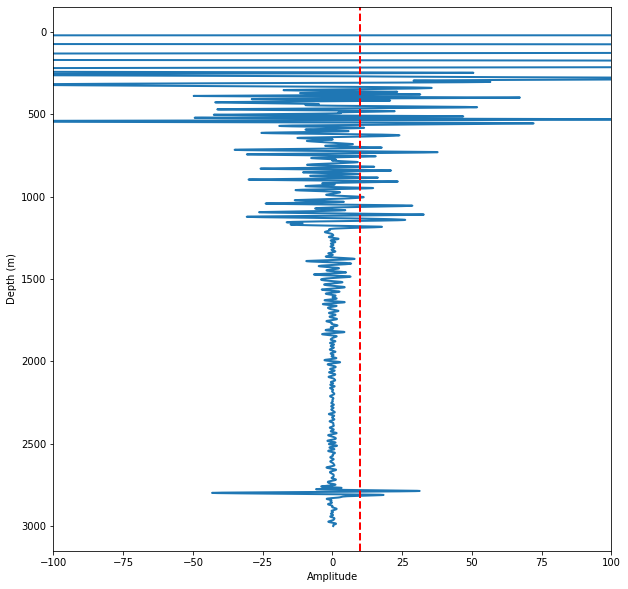

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
plot.plot_traces(dat, 1000, ydat='depth', linewidth=2.0, linestyle='solid', fig=fig, ax=ax)
ax.set_xlim(-100, 100)
ax.axvline(x=10, linestyle='--', color='r', linewidth=2.0)
plt.show()

**Notes:**
- contour_troughs and contour_troughs are the same thing except for positive and negative contours. Still, they show interesting imagery.
- contourMiddle_many and contourMiddle_many_negative basically show the same thing, but the latter's code is much cleaner
- contour single could be a good place to start, and contains animation for contours

- I don't think that I need create_internal_reflectors.py
- in autopicker_methods.py, find_troughs() should work for both positive and negative contours. *TEST THIS*.

## Algorithm Outline

The general processing flow should be something like this:
- Find the contours for a certain value.
- Find the left- and right-most x values in a contour, and use them to find the unique x values that span each contour.
- Find the central points inside the contours (maximima for ridges, minima for troughs), and get rid of those points for which we have less than two or more than three y values for each unique x value along the contour.
- Check to make sure that our unique x and central value list have non-zero lengths, meaning that we were able to find values for that contour. Note: for some contours along the top of the profile, this method is sometimes unable to find central values and thus we should not include them.
- Check to make sure that our unique x and central value lists have the same length
- Then find the top and bottom of the wave packet so that we can calculate power for each pick (which is what I would consider what we have at this point).

The whole process should be more or less automatic. It is recommended that the user look along a track beforehand to pick the value in the `find_contours()` method.

## Future Work

#### Working on smoothing the contours to improve ability to pick ridges and troughs

#### Stitching together the contours so that we have continuous contours

#### Sorting Contours

Since we have the ridges, we should be able to sort them by their starting index. So for each ridge:
- we need to sort by x and y index (bubble sort?)
- https://www.geeksforgeeks.org/bubble-sort/
- https://en.wikipedia.org/wiki/Bubble_sort


- compare starting x points. is it before the previous contour?
- if no, skip
- if yes, is its y point higher? this is in an attempt to push contours closer to the upper left corner first, while pushing those towards the lower right down in the list

## Caveats
Here are some caveats to this method:
- For especially noisy profiles, this contouring method will not yield desirable results. This method is only as good as the processing steps that proceed it.
- That being said, this method works best for ice sheet data with planar, visibly continuous layers.
- Picks near the bed are not classified well. However, this method is not currently meant to pick the bed, but only internal reflectors. There are already a plethora of methods for picking the surface and bed of a radargram, although they are not currently implemented with this autopicking method.
- The fully automatic picker will pick contours below the bed since we are using an image processing approach: the autopicker does currently discern between what is and what isn't the bed-rock interface, it simply looks at "pixel" values.

It is my hope that this tutorial has been a sufficient walk-through of how the current automatic picker works, so that future collaborators can either expand upon or draw from the current implementation.